# Linear Regression

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

In this notebook, JAX will be used to solve a basic linear regression problem: given inputs $X$ and targets $y$, find the weights $w$ and bias $b$ 
that minimizes the loss function.

$$
    \ell (w, b) = \| X w + b - y \| ^ 2
$$

In the process of solving this problem, I'll slowly build up a basic neural network library.

In [1]:
import jax 
import jax.numpy as jnp
from jax import grad, random
import numpy as np
import matplotlib.pyplot as plt

## Generate Data

The first thing I need to to is generate some mock data.  To do this, I define a fixed three-dimensional weight vector `w` and scalar bias `b`, that describe a hyperplane.  

In [ ]:
w = jnp.array([1.0, 2.0, 3.0])
b = 4.0 

Next, I'm going to generate a bunch of random points satisfying the equation

$$
    y = x \cdot w + b
$$


In [44]:

seed = 3551
key = random.PRNGKey(seed)
X = random.normal(key, (10, 3))

y = jnp.dot(X, w) + b

## Model Definition

We use a simple linear model, with the parameters (weights and biases) stored in a simple python dictionary, named `params`.

In [18]:
def linear_model(params, X):
    w = params['w']
    b = params['b']
    return jnp.dot(X, w) + b

## Loss Function

The loss function takes the current set of parameters, the model, and the data and calculates the distance between the model
predictions and the targets.  

In [19]:
def mse_loss(params, model, data):
    X, y = data
    l = model(params, X) 
    return jnp.mean((l - y)**2) 

I don't like the fact that the `params` dictionary and the model are both passed as arguments to the loss function.  Eventually, I'd like to keep the `params` dictionary in some sort of model object, pass the model to the loss, and have the model implementation handle all the parameter specific stuff.  

## Training Loop

The training loop tunes the model parameters for a specified number of epochs.  For now the parameters are adjusted once per epoch, after the entire dataset is consumed by the model.  

In [34]:
def train(lr=1e-2, model=linear_model, num_epochs=50, data = (X, y), loss=mse_loss):
    
    X, y = data
    loss_vals = np.zeros(num_epochs)

    # differentiate the loss with respect to the params, which is the zeroth argument number
    fn = jax.value_and_grad(loss, argnums=0) 

    # initialize the model parameters
    params = {'w': jnp.array([0,0,0], dtype=jnp.float32), 'b': 0.0}

    for i in range(num_epochs):
        loss_i, grad_params_i = fn(params, model, data)
        for key in params:
            params[key] -= lr*grad_params_i[key]
    
        loss_vals[i] = loss_i
    return loss_vals, params

In [40]:
num_epochs, lr = 500, 1e-2
loss_values, params = train(lr=lr, num_epochs=num_epochs, model=linear_model)


{'w': DeviceArray([1.0605003, 1.952814 , 2.9707012], dtype=float32), 'b': DeviceArray(4.0229278, dtype=float32, weak_type=True)}


In [43]:
print(params)
w_error = jnp.sum((params['w'] - w)**2) / jnp.sum(w**2)
b_error = jnp.abs((params['b'] - b)) / jnp.abs(b)

print(f'w error = {w_error*100} %')
print(f'b error = {b_error*100} %')

{'w': DeviceArray([1.0605003, 1.952814 , 2.9707012], dtype=float32), 'b': DeviceArray(4.0229278, dtype=float32, weak_type=True)}
w error = 0.04818015173077583 %
b error = 0.5731940269470215 %


It looks like the learned parameters are pretty close to the parameters used to generate the initial dataset.  This means the training loop is working properly.

## Performance Curve

Let's see the trend in the loss function.

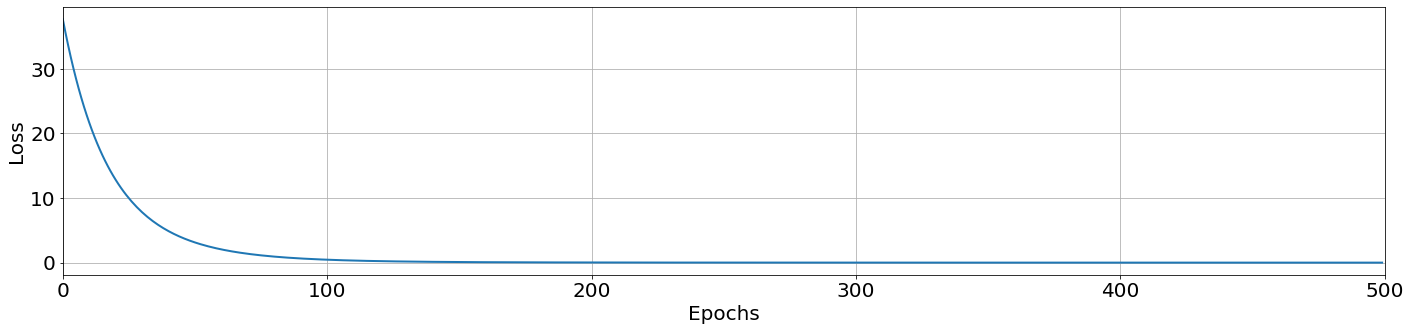

In [39]:
plt.rcParams['font.size'] = 20
plt.figure(1, figsize=(20,5))
plt.plot(np.arange(num_epochs), loss_values, linewidth=2)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, num_epochs)
plt.tight_layout()

## Conclusion

Linear regression is pretty simple, particulary when you have access to an automatic differentiation tool.